# Classifying Names with Character Level RNN - with LSTM

Welcome! In this assigment you will learn to build a recurrent net to help classify names to their country.

1. ***Input:*** Kawachi ***output:*** Japanese
2. ***Input:*** Watson ***output:*** Scottish

Why do we need LSTM??

1. To retain LongTerm dependencies in the input-sequence
2. Address Vanishing Gradient problem!!

*** Model Structure/Overview ***
<img src = "images/rnn_2.png">

In [15]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string

# Overview

We are going to build the network shown above for using the "ordering" information in classifying names.

***How to interpret the diagram:***

1. The arrows represent flow of information/data
2. Yellow boxes -> Input/Output to the network
3. Blue boxes -> Variables/parameters/activation in the Network

***You are going to code the following portions:***

1. RNN Class - Incorporate nn.LSTM module instead of the Linear Module

***What you need not code***

1. Loading files
2. Basic String Processing
3. Training phase - input processing
4. Most of code from previous exercise

However, I would suggest that it would be a good exercise to read the utilites and understand them before proceeding.

Lets get started!!

In [16]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/RNN/names/*.txt'))

['data/RNN/names/Arabic.txt', 'data/RNN/names/Chinese.txt', 'data/RNN/names/Czech.txt', 'data/RNN/names/Dutch.txt', 'data/RNN/names/English.txt', 'data/RNN/names/French.txt', 'data/RNN/names/German.txt', 'data/RNN/names/Greek.txt', 'data/RNN/names/Irish.txt', 'data/RNN/names/Italian.txt', 'data/RNN/names/Japanese.txt', 'data/RNN/names/Korean.txt', 'data/RNN/names/Polish.txt', 'data/RNN/names/Portuguese.txt', 'data/RNN/names/Russian.txt', 'data/RNN/names/Scottish.txt', 'data/RNN/names/Spanish.txt', 'data/RNN/names/Vietnamese.txt']


# String Processing

In [17]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Load Files

In [18]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


for filename in findFiles('data/RNN/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# One hot encoding of Input

In [19]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)


def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


# The RNN Module - Yay!

<img src = "images/rnn_2.png">

Code the above depicted network!! 

***Dont worry about using nn.RNN Module now. We will use it in the next exercise. For now focus on understanding how "recurrence" relation is captured in PyTorch.***

I have already typed out the LHS - You need to fill-in the RHS taking help from the comments that preceed each line.

***For each line of code please look up the diagram above to understand the flow of logic***

Use LSTM for ***i2h*** layer - beware of hidden and state information.. how to combine?? Experiment

***How to interpret the diagram:***

1. The arrows represent flow of information/data
2. Yellow boxes -> Input/Output to the network
3. Blue boxes -> Variables/parameters/activation in the Network

For any syntax clarification look up: http://pytorch.org/docs/master/nn.html

In [20]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTM(input_size + 2*hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + 2*hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden,state):
        combined = torch.cat((input, hidden.view(1,-1),state.view(1,-1)), 1)
        _,hidden = self.i2h(combined,(hidden,state)) 
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, 1,self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

# Utitlity code to generate one training example at a time

***randomTrainingExample()*** -> return a training example in the following format

1. Category: which language the word is from
2. Line: the word itself
3. Category_tensor: Which category the word belongs (index position) (label information)
4. Line_tensor: one-hot representation of the word (len(word),1,n_letters)

In [22]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Gerver
category = Greek / line = Kotsilimbas
category = Portuguese / line = Lobo
category = German / line = Auer
category = Chinese / line = Tang
category = Italian / line = Sgro
category = Arabic / line = Hajjar
category = Greek / line = Zaloumi
category = Chinese / line = Zhou
category = Portuguese / line = Ferreiro


# Defining your Loss - nn.NLLoss()

In [23]:
criterion = nn.NLLLoss()

# Training your Network

1. Define hidden layer
2. zero-out rnn grad
3. for each input/character
    1. output,hidden = rnn(inout_char,hidden)
4. Compute loss
5. backpropagate loss though the network for the entire word
6. for every weight matrix in rnn.parameters()
    1.Do a gradient descent on rnn parameters using p.data.add_ utility
7. return output and loss value!

In [24]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    state = rnn.initHidden()
    
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, t = rnn(line_tensor[i],hidden,state)
        hidden,state = t[0],t[1]    
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

# Given the softmax output, classify into one of the 18 categories.

In [26]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

# Time to run your code!

***For a number of times do the following***

1. Generate random example - use randomTrainingExample()
2. train on category tensor as label, and line_tensor as inputs in train function
3. compute loss - cumulative

In [27]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 46s) 2.3452 Nishimoto / Portuguese ✗ (Japanese)
10000 10% (1m 32s) 1.8815 Coghlan / Irish ✓
15000 15% (2m 13s) 1.2495 Choi / Vietnamese ✗ (Korean)
20000 20% (2m 55s) 1.8466 Kouri / Italian ✗ (Arabic)
25000 25% (3m 37s) 1.0908 Slusarski / Polish ✓
30000 30% (4m 19s) 1.1861 Couture / French ✓
35000 35% (5m 1s) 1.5094 Kavanagh / Irish ✓
40000 40% (5m 42s) 0.9403 Sauvageot / French ✓
45000 45% (6m 23s) 0.1984 Sakellariou / Greek ✓
50000 50% (7m 3s) 0.5148 Chu / Vietnamese ✓
55000 55% (7m 44s) 1.5449 Williamson / Russian ✗ (Scottish)
60000 60% (8m 25s) 0.1955 O'Ryan / Irish ✓
65000 65% (9m 6s) 2.1639 Kikkert / Japanese ✗ (Dutch)
70000 70% (9m 46s) 0.1950 Snyders / Dutch ✓
75000 75% (10m 27s) 0.1779 Hadad / Arabic ✓
80000 80% (11m 7s) 0.8776 Pavlicka / Czech ✓
85000 85% (11m 50s) 0.0410 Romeijnsen / Dutch ✓
90000 90% (432m 27s) 1.6818 Courtemanche / Russian ✗ (French)
95000 95% (492m 24s) 0.4577 Vuu / Vietnamese ✓
100000 100% (493m 15s) 0.5694 Gonzalez / Spanish ✓


# Plot the loss

***if loss reducing==True:***

Feel happy seeing loss!! Congratz... Great Job..

***else:***

Oops.. not reducing - something somewhere went wrong. Please re-read comments/pointers.. Just be careful while coding..No worries!

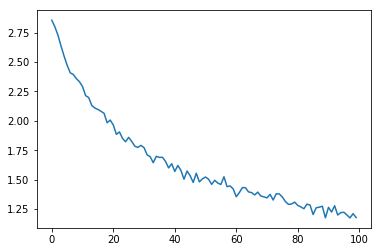

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

# Visualize Confusion Matrix on Evaluation

Just run the cell below - and visualize confusion matrix!

Please read the code at leisure.. It is worth understanding how to compute the confusion matrix and visualizing the output..

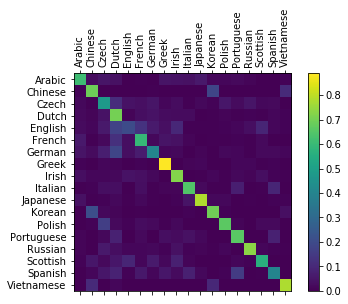

In [29]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    state = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, t = rnn(line_tensor[i], hidden,state)
        hidden,state = t[0],t[1]

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Sayanora

Great! Hope this assignment was useful and productive.. Looking forward for our next session on LSTM`